In [19]:
## HW3 DATSCI W261 

**Names** Safyre Anderson, Howard Wen , Vamsi Sakhamuri

**Emails** safyre@berkelye.edu, howard.wen1@gmail.com, vamsi@ischool.berkeley.edu 

**Time of Initial Submission:** February 4nd, 2016 8am PST

**Section** W261-3, Spring 2016  

**Week** 3 Homework

### HW 3.0.
*What is a merge sort? Where is it used in Hadoop?*

*How is  a combiner function in the context of Hadoop?* 

*Give an example where it can be used and justify why it should be used in the context of this problem.*

*What is the Hadoop shuffle?*



### HW3.1 Use Counters to do EDA (exploratory data analysis and to monitor progress)
*Counters are lightweight objects in Hadoop that allow you to keep track of system progress in both the map and reduce stages of processing. By default, Hadoop defines a number of standard counters in "groups"; these show up in the jobtracker webapp, giving you information such as "Map input records", "Map output records", etc. 
While processing information/data using MapReduce job, it is a challenge to monitor the progress of parallel threads running across nodes of distributed clusters. Moreover, it is also complicated to distinguish between the data that has been processed and the data which is yet to be processed. The MapReduce Framework offers a provision of user-defined Counters, which can be effectively utilized to monitor the progress of data across nodes of distributed clusters.
Use the Consumer Complaints  Dataset provide here to complete this question:*
    

     https://www.dropbox.com/s/vbalm3yva2rr86m/Consumer_Complaints.csv?dl=0

*The consumer complaints dataset consists of diverse consumer complaints, 
which have been reported across the United States regarding various types of loans. 
The dataset consists of records of the form:*

Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Submitted via,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?

*Here’s is the first few lines of the  of the Consumer Complaints  Dataset:*

`Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Submitted via,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?
1114245,Debt collection,Medical,Disclosure verification of debt,Not given enough info to verify debt,FL,32219,Web,11/13/2014,11/13/2014,"Choice Recovery, Inc.",Closed with explanation,Yes,
1114488,Debt collection,Medical,Disclosure verification of debt,Right to dispute notice not received,TX,75006,Web,11/13/2014,11/13/2014,"Expert Global Solutions, Inc.",In progress,Yes,
1114255,Bank account or service,Checking account,Deposits and withdrawals,,NY,11102,Web,11/13/2014,11/13/2014,"FNIS (Fidelity National Information Services, Inc.)",In progress,Yes,
1115106,Debt collection,"Other (phone, health club, etc.)",Communication tactics,Frequent or repeated calls,GA,31721,Web,11/13/2014,11/13/2014,"Expert Global Solutions, Inc.",In progress,Yes,`





In [14]:
## First prepare local hadoop cluster in pseudo-distributed mode
#!source ~/.bash_profile
#!cd $HADOOP_HOME
#!$HADOOP_HOME/sbin/start-dfs.sh

#!$HADOOP_HOME/bin/hadoop namenode -format
!$HADOOP_HOME/sbin/start-yarn.sh
#!$HADOOP_HOME/sbin/stop-dfs.sh
#!$HADOOP_HOME/sbin/stop-yarn.sh


starting yarn daemons
starting resourcemanager, logging to /usr/local/hadoop-2.7.1/logs/yarn-Safyre-resourcemanager-Safyres-MacBook-Pro.local.out
localhost: starting nodemanager, logging to /usr/local/hadoop-2.7.1/logs/yarn-Safyre-nodemanager-Safyres-MacBook-Pro.local.out


In [15]:
# Check PIDS
!jps

3520 SecondaryNameNode
3314 NameNode
3779 NodeManager
3685 ResourceManager
3404 DataNode
3820 Jps


In [13]:
# check dfs
!hdfs dfs -ls /
!hdfs dfs -ls /user/safyre

16/01/30 14:38:43 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 3 items
drwx------   - Safyre supergroup          0 2016-01-30 00:13 /tmp
drwxr-xr-x   - Safyre supergroup          0 2016-01-30 00:41 /user
drwxr-xr-x   - Safyre supergroup          0 2016-01-30 00:36 /usr
16/01/30 14:38:44 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
drwxr-xr-x   - Safyre supergroup          0 2016-01-30 14:38 /user/safyre/input
drwxr-xr-x   - Safyre supergroup          0 2016-01-30 00:11 /user/safyre/output


In [16]:
# Download assignment data and the "put" into hdfs input folder
!wget -O $HADOOP_HOME/input/Consumer_Complaints.csv https://www.dropbox.com/s/vbalm3yva2rr86m/Consumer_Complaints.csv?dl=0
!hdfs dfs -put $HADOOP_HOME/input/Consumer_Complaints.csv /user/safyre/input

--2016-01-30 14:41:04--  https://www.dropbox.com/s/vbalm3yva2rr86m/Consumer_Complaints.csv?dl=0
Resolving www.dropbox.com... 108.160.172.206, 108.160.172.238
Connecting to www.dropbox.com|108.160.172.206|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://dl.dropboxusercontent.com/content_link/yhmyJdTC9ibqDpuGPBMZV3j9mceF8Dn95CjcDFb4Y141LlH45d1jeU5EoH8kmq31/file [following]
--2016-01-30 14:41:05--  https://dl.dropboxusercontent.com/content_link/yhmyJdTC9ibqDpuGPBMZV3j9mceF8Dn95CjcDFb4Y141LlH45d1jeU5EoH8kmq31/file
Resolving dl.dropboxusercontent.com... 199.47.217.69
Connecting to dl.dropboxusercontent.com|199.47.217.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50906486 (49M) [text/csv]
Saving to: '/usr/local/hadoop-2.7.1/input/Consumer_Complaints.csv'

/usr/local/hadoop-2 100%[=====================>]  48.55M  3.09MB/s   in 15s    

2016-01-30 14:41:23 (3.15 MB/s) - '/usr/local/hadoop-2.7.1/input/Consumer_Complaints.csv' 

### HW 3.1.1  **User-defined Counters**

*Now, let’s use Hadoop Counters to identify the number of complaints pertaining to **debt collection, mortgage, and other categories** (all other categories get lumped into this one) in the consumer complaints dataset. Basically produce the distribution of the Product column in this dataset using counters (limited to 3 counters here).*

*Hadoop offers Job Tracker, an UI tool to determine the status and statistics of all jobs. Using the job tracker UI, developers can view the Counters that have been created. Screenshot your  job tracker UI as your job completes and include it here. Make sure that your user defined counters are visible.*

In [ ]:
## reiterate what could be in the data
'''Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Submitted via,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?
1114245,Debt collection,Medical,Disclosure verification of debt,Not given enough info to verify debt,FL,32219,Web,11/13/2014,11/13/2014,"Choice Recovery, Inc.",Closed with explanation,Yes,'''

## Looks like we just need to map counts (1's) to each key: Product.


In [61]:
%%writefile mapper.py
#!/usr/bin/env python
import sys

# delimiter
delim = ','

for index, line in enumerate(sys.stdin):
    
    # split by delimiter
    sections = line.split(delim)
    
    # skip the headers and bad rows
    if (index == 0) or (len(sections) == 0):
        continue
        
    else:
        # get complaints, each row should be a new complain
        PRODUCT = sections[1]
        PRODUCT = PRODUCT.lower()
        
        # collapse exclusive products to 'other'
        if PRODUCT not in ["debt collection", "mortgage"]:
            PRODUCT = "other"
        value = 1
        
        if PRODUCT == "debt collection":
            sys.stderr.write("reporter:counter:Products,Debt Collection,1\n")
        elif PRODUCT == "mortgage":
            sys.stderr.write("reporter:counter:Products,Mortgage,1\n")
        else:
            sys.stderr.write("reporter:counter:Products,Other,1\n")
        print "%s\t%d" % (PRODUCT, value)

Overwriting mapper.py


In [35]:
%%writefile reducer.py
#!/usr/bin/env python

import sys

#set up a counts dictionary
counts_dict = {}

for line in sys.stdin:
    key, value = line.split('\t')
    
    counts_dict.setdefault(key,0)
    counts_dict[key] += int(value)

# print out each reduced key value pair

for product in counts_dict:
    print "The product " + product + " has " + str(counts_dict[product]) + " complaints."




Overwriting reducer.py


In [62]:
## lazy
!chmod a+x *.py

In [15]:
## practice run with poor mans' MR
!head -n1000 $HADOOP_HOME/input/Consumer_Complaints.csv | ./mapper.py |sort | ./reducer.py

In [39]:
# start the jobtracker server:
!$HADOOP_HOME/sbin/mr-jobhistory-daemon.sh --config $HADOOP_HOME/etc/hadoop/ start historyserver 

starting historyserver, logging to /usr/local/hadoop-2.7.1/logs/mapred-Safyre-historyserver-Safyres-MacBook-Pro.local.out


In [14]:
## Now with Hadoop Streaming
# for some reason hadoop throws an exception because it can't find the 
###   Error: java.lang.RuntimeException: Error in configuring object
###   ... Caused by: java.io.IOException: 
###   Cannot run program "reducer.py": error=2, 
###   No such file or directory
# mapper.py and reducer.py. Added -file arguments for both

!hdfs dfs -rm -r /user/safyre/output3_1
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
    -file mapper.py \
    -mapper mapper.py \
    -file reducer.py \
    -reducer reducer.py \
    -input "/user/safyre/input/Consumer_Complaints.csv" \
    -output "/user/safyre/output3_1"


'!hdfs dfs -rm -r /user/safyre/output3_1\n!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar     -file mapper.py     -mapper mapper.py     -file reducer.py     -reducer reducer.py     -input "/user/safyre/input/Consumer_Complaints.csv"     -output "/user/safyre/output3_1"'

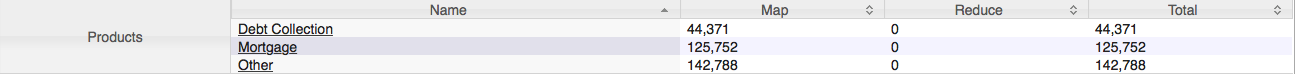

In [65]:
# Counted 2 map tasks and 1 reduce task. Shouldn't there be one reduce task per key?
from IPython.display import Image
Image(filename='3_1_counters.png')

### HW 3.2 Analyze the performance of your Mappers, Combiners and Reducers using Counters

*For this brief study the Input file will be one record (the next line only):*

`foo foo quux labs foo bar quux`


### 3.2.1 

*Perform a word count analysis of this single record dataset using a Mapper and Reducer based WordCount (i.e., no combiners are used here) using user defined Counters to count up how many time the mapper and reducer are called. What is the value of your user defined Mapper Counter, and Reducer Counter after completing this word count job. The answer  should be 1 and 4 respectively. Please explain.*

In [91]:
## create and insert the one line input file
#!echo "foo foo quux labs foo bar quux" >> $HADOOP_HOME/input/3_2_1.txt
!hdfs dfs -put $HADOOP_HOME/input/3_2_1.txt /user/safyre/input
!hdfs dfs -ls /user/safyre/input

16/01/30 19:34:20 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/30 19:34:21 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/safyre/input/3_2_1.txt
16/01/30 19:34:22 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/30 19:34:23 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   1 Safyre supergroup         31 2016-01-30 19:34 /user/safyre/input/3_2_1.txt
-rw-r--r--   1 Safyre supergroup   50906486 2016-01-30 14:41 /user/safyre/input/Consumer_Complaints.csv


In [155]:
%%writefile mapper.py
#!/usr/bin/env python
#based on lecture code

import sys

# map count
sys.stderr.write("reporter:counter:Calls,Num mapper calls,1\n")

# read in one line
for line in sys.stdin:
    for token in line.strip().split(" "):
        if token: # check if token is actually a word and not None
            #sys.stderr.write("reporter:counter:Words,Total,1\n")
            print token+"\t1"
        

Overwriting mapper.py


In [156]:
%%writefile reducer.py
#!/usr/bin/env python
# based on lecture code
import sys

# initialize tuple for reducing
(lastKey, sum) = (None, 0)

# reduce count
sys.stderr.write("reporter:counter:Calls,Num reducer calls,1\n")

# read in one line
for line in sys.stdin:
    (key, value) =  line.strip().split("\t")
    
    ## if we get a new key that is different from the last key (lastKey)
    ## print out the sum we've calculated so far for lastKey
    ## and start again with key as the new lastKey
    if lastKey and lastKey != key:
        #sys.stderr.write("reporter:counter:Keys,"+lastKey+",1\n")
        print lastKey + "\t" + str(sum)
        (lastKey, sum) = (key, int(value))
    
    ## else, just keep counting
    else:
        (lastKey, sum) = (key, sum + int(value))

## The very last key won't be printed within the for loop
## so print it here
if lastKey:
    #sys.stderr.write("reporter:counter:Keys,"+lastKey+",1\n")
    print lastKey + '\t' + str(sum)

Overwriting reducer.py


In [157]:
!chmod a+x *.py

In [158]:
## test with poor man's
!cat  $HADOOP_HOME/input/3_2_1.txt | ./mapper.py | sort | ./reducer.py

reporter:counter:Calls,Num mapper calls,1
reporter:counter:Calls,Num reducer calls,1
bar	1
foo	3
labs	1
quux	2


In [13]:
## hadoop streaming
!hdfs dfs -rm -r /user/safyre/output3_2_1
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
    -D mapred.reduce.tasks=4\
    -file mapper.py \
    -mapper mapper.py \
    -file reducer.py \
    -reducer reducer.py \
    -input "/user/safyre/input/3_2_1.txt" \
    -output "/user/safyre/output3_2_1"


'!hdfs dfs -rm -r /user/safyre/output3_2_1\n!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar     -D mapred.reduce.tasks=4    -file mapper.py     -mapper mapper.py     -file reducer.py     -reducer reducer.py     -input "/user/safyre/input/3_2_1.txt"     -output "/user/safyre/output3_2_1"'

**ANSWER**: Initially with default settings, I was getting 2 mappers and one reducer. It was only after setting the number of reduce tasks to 4 that I got 4 reducers. However, I was still getting two mappers: with only one line per key-value pair and no secondary sorting there should only be one mapper. It's not quite clear to me why the file is still being split to two mappers--it may be a default feature of Hadoop streaming. Additionally, Hadoop should be allocating one key per reducer. Since there are 4 keys in this dataset, I thought Hadoop would automatically spin up a reducer for each key.

### 3.2.2 

*Please use mulitple mappers and reducers for these jobs (at least 2 mappers and 2 reducers).*
*Perform a word count analysis of the Issue column of the Consumer Complaints  Dataset using a Mapper and Reducer based WordCount (i.e., no combiners used anywhere)  using user defined Counters to count up how many time the mapper and reducer are called. What is the value of your user defined Mapper Counter, and Reducer Counter after completing your word count job.*

In [160]:
%%writefile mapper.py
#!/usr/bin/env python
# based on lecture code

## Word count in the Issue column, this is the 4th column
## or 3rd index

import sys
import string
from nltk.corpus import stopwords
delim = ","

# get a translation table ready to strip punctuation
translate_table = string.maketrans(" "," ")

# Getting limitexceeded warning. Hoping this will
# reduce number of counters
stop_list = stopwords.words('english')

sys.stderr.write("reporter:counter:group,Num mapper calls,1\n")
for index, line in enumerate(sys.stdin):
    
    # split by delimiter
    sections = line.split(delim)
    
    # skip the headers and bad rows
    if (index == 0) or (len(sections) == 0):
        continue
    # Grab issue column only
    issues = sections[3].lower()
    
    #strip punctuation
    issues = issues.translate(translate_table, string.punctuation)
    
    for token in issues.strip().split(" "):
        if token and token not in stop_list: # check if token is actually a word and not None
            print token+"\t1"

Overwriting mapper.py


In [161]:
%%writefile reducer.py
#!/usr/bin/env python
# based on lecture code
import sys

sys.stderr.write("reporter:counter:group,Num reducer calls,1\n")
# initialize tuple for reducing
(lastKey, sum) = (None, 0)

# read in one line
for line in sys.stdin:
    (key, value) =  line.strip().split("\t")
    
    ## if we get a new key that is different from the last key (lastKey)
    ## print out the sum we've calculated so far for lastKey
    ## and start again with key as the new lastKey
    if lastKey and lastKey != key:
        print lastKey + "\t" + str(sum)
        (lastKey, sum) = (key, int(value))
    
    ## else, just keep counting
    else:
        (lastKey, sum) = (key, sum + int(value))

## The very last key won't be printed within the for loop
## so print it here
if lastKey:
    
    print lastKey + '\t' + str(sum)

Overwriting reducer.py


In [12]:
!chmod a+x *.py
!head -n1000 $HADOOP_HOME/input/Consumer_Complaints.csv |./mapper.py | sort | ./reducer.py

In [101]:
# get input file location again
!hdfs dfs -ls /user/safyre/input

16/01/30 20:13:30 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   1 Safyre supergroup         31 2016-01-30 19:34 /user/safyre/input/3_2_1.txt
-rw-r--r--   1 Safyre supergroup   50906486 2016-01-30 14:41 /user/safyre/input/Consumer_Complaints.csv


In [11]:
## hadoop streaming
## Kept getting memory erros, need to increase block size!
## also got this interesting error from job's syslog file in chunk 02
## in $HADOOP_HOME/logs/userlogs/application_1454192816461_0024/container_1454192816461_0024_01_000002
## "rg.apache.hadoop.streaming.PipeMapRed: 
##    org.apache.hadoop.mapreduce.counters.LimitExceededException: Too many counters: 121 max=120"

## SOLUTION: set the mapreduce.job.counters.max = 300 (was getting 169 counters)

!hdfs dfs -rm -r /user/safyre/output3_2_2
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
    -D mapreduce.job.maps=2 \
    -D mapreduce.job.reduces=2\
    -file mapper.py \
    -file reducer.py \
    -mapper mapper.py \
    -reducer reducer.py \
    -input "/user/safyre/input/Consumer_Complaints.csv" \
    -output "/user/safyre/output3_2_2"



'!hdfs dfs -rm -r /user/safyre/output3_2_2\n!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar     -D mapreduce.job.maps=2     -D mapreduce.job.reduces=2    -file mapper.py     -file reducer.py     -mapper mapper.py     -reducer reducer.py     -input "/user/safyre/input/Consumer_Complaints.csv"     -output "/user/safyre/output3_2_2"'

In [10]:
!hdfs dfs -cat /user/safyre/output3_2_2/part-00000

### 3.2.3 

*Perform a word count analysis of the Issue column of the Consumer Complaints  Dataset using a Mapper, Reducer, and standalone combiner (i.e., not an in-memory combiner) based WordCount using user defined Counters to count up how many time the mapper, combiner, reducer are called. What is the value of your user defined Mapper Counter, and Reducer Counter after completing your word count job.* 


In [164]:
%%writefile combiner.py
#!/usr/bin/env python
# Combiner, combining counts
# sums are associative and commutative
# a combiner can take advantage of these properties
# to try to achieve some performance gains--i.e. fewer spillovers
import sys

sys.stderr.write("reporter:counter:group,Num combiner calls,1\n")
# initialize tuple for reducing
(lastKey, sum) = (None, 0)

# read in one line
for line in sys.stdin:
    (key, value) =  line.strip().split("\t")
    
    ## if we get a new key that is different from the last key (lastKey)
    ## print out the sum we've calculated so far for lastKey
    ## and start again with key as the new lastKey
    if lastKey and lastKey != key:
        print lastKey + "\t" + str(sum)
        (lastKey, sum) = (key, int(value))
    
    ## else, just keep counting
    else:
        (lastKey, sum) = (key, sum + int(value))

## The very last key won't be printed within the for loop
## so print it here
if lastKey:
    
    print lastKey + '\t' + str(sum)

Overwriting combiner.py


In [165]:
!chmod a+x *.py

In [9]:
## redo with a combiner
!hdfs dfs -rm -r /user/safyre/output3_2_3
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
    -D mapreduce.job.maps=2 \
    -D mapreduce.job.reduces=2\
    -file mapper.py \
    -file reducer.py \
    -file combiner.py \
    -mapper mapper.py \
    -reducer reducer.py \
    -combiner combiner.py \
    -input "/user/safyre/input/Consumer_Complaints.csv" \
    -output "/user/safyre/output3_2_3"

'!hdfs dfs -rm -r /user/safyre/output3_2_3\n!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar     -D mapreduce.job.maps=2     -D mapreduce.job.reduces=2    -file mapper.py     -file reducer.py     -file combiner.py     -mapper mapper.py     -reducer reducer.py     -combiner combiner.py     -input "/user/safyre/input/Consumer_Complaints.csv"     -output "/user/safyre/output3_2_3"'

**ANSWER:** The mapper, combiner, and reducer were called 4, 2, and 2 times respectively. Adding the combiner improved the the GC (garbage collection) time by 24 ms, reduced the records load on the mapper and reducer tasks, and reduced spillover from 1,606,924 records to 534 records. 

### 3.2.4 

*Using a single reducer: What are the top 50 most frequent terms in your word count analysis? Present the top 50 terms and their frequency and their relative frequency. If there are ties please sort the tokens in alphanumeric/string order. Present bottom 10 tokens (least frequent items).* 

In [ ]:
%%writefile combiner.py
#!/usr/bin/env python
# Combiner, combining counts
# sums are associative and commutative
# a combiner can take advantage of these properties
# to try to achieve some performance gains--i.e. fewer spillovers
import sys

sys.stderr.write("reporter:counter:group,Num combiner calls,1\n")
# initialize tuple for reducing
(lastKey, sum) = (None, 0)

# also output the overall sum for relative frequencies
total_count = 0

# read in one line
for line in sys.stdin:
    (key, value) =  line.strip().split("\t")
    
    ## if we get a new key that is different from the last key (lastKey)
    ## print out the sum we've calculated so far for lastKey
    ## and start again with key as the new lastKey
    ### for this part, reverse the key and values to sort by frequencies
    if lastKey and lastKey != key:
        print  lastKey + "\t" + str(sum)
        (lastKey, sum) = (key, int(value))
    
    ## else, just keep counting
    else:
        (lastKey, sum) = (key, sum + int(value))
        total_count += int(value)

## The very last key won't be printed within the for loop
## so print it here
if lastKey:
    print lastKey + "\t" + str(sum) 
    
## Finally, print the count of all words
print  "*" + "\t" + str(total_count) #+ str(1)

In [228]:
%%writefile reducer.py
#!/usr/bin/python
# based on solutions from homework 2

## However, the idea here is the keys are now the words,
# but we are sorting by value (sum)

import sys, Queue

# set number of top and bottom frequencies
n_max, n_min = 50, 10
q_max = Queue.Queue(n_max)
a_min = []
total_count = 0

for line in sys.stdin:
    rec = line.split('\t')
    rec[1] =rec[1].strip()
    
    # grab the total counts to get relative frequencies
    if rec[0] == "*":
        total_count = int(rec[1])
        continue
    
    # put the smallest values into the list until
    # the list size = 10
    if len(a_min) < n_min:
        a_min.append('\t'.join(rec))
        
    
    # once the queue is full (50 items)
    # remove and return the values
    if q_max.full():
        q_max.get()
        
    # put the remainders into the queue as lists
    q_max.put('\t'.join(rec))

print '\n%d smallest records:' %n_min
for record in a_min:
    print record

print '\n%d biggest records:' %n_max
for i in range(n_max):
    print q_max.get()

Overwriting reducer.py


In [272]:
%%writefile reducer2.py
#!/usr/bin/python
# Rewriting the reducer to try and combine the counts

## However, the idea here is the keys are now the words,
# but we are sorting by value (sum)

import sys, Queue

# initialize tuple for reducing
[lastKey, keysum] = [None, 0]

# also output the overall sum for relative frequencies
total_count = 0
all_kv = []

# read in one line
for line in sys.stdin:
    [key, value] =  line.strip().split("\t")
    
    ## if we get a new key that is different from the last key (lastKey)
    ## print out the sum we've calculated so far for lastKey
    ## and start again with key as the new lastKey
    ### for this part, reverse the key and values to sort by frequencies
    if lastKey and lastKey != key:
        [lastKey, keysum] = [key, int(value)]
        all_kv.append([lastKey, str(keysum)])
        total_count += keysum
        
    ## else, just keep counting
    else:
        [lastKey, keysum] = [key, keysum + int(value)]

## Finally, print the count of all words
all_kv.append(["*", str(total_count)])


## now grab top 50 and bottom 10
# set number of top and bottom frequencies
n_max, n_min = 50, 10
q_max = Queue.Queue(n_max)
a_min = []

for rec in all_kv:  
    # grab the total counts to get relative frequencies
    if rec[0] == "*":
        total_count = int(rec[1])
        continue
    
    # put the smallest values into the list until
    # the list size = 10
    if len(a_min) < n_min:
        a_min.append('\t'.join(rec))
        
    
    # once the queue is full (50 items)
    # remove and return the values
    if q_max.full():
        q_max.get()
        
    # put the remainders into the queue as lists
    q_max.put('\t'.join(rec))

print '\n%d smallest records:' %n_min
for record in a_min:
    print record

print '\n%d biggest records:' %n_max
for i in range(n_max):
    print q_max.get()

Overwriting reducer2.py


In [273]:
!chmod a+x *.py

In [8]:
## poor mans version
# k 2,2 means sort on second field only
# rn means reverse (desc) numeric sort
!head -n1000 $HADOOP_HOME/input/Consumer_Complaints.csv |./mapper.py |sort |./combiner.py|sort -k2,2n -k1,1 | ./reducer2.py #|head -n50


In [7]:
## redo with a combiner
## Some notes on the mapred parameters
#    stream.num.map.output.key.fields=2, tells hadoop both fields (we only have two) should be treated like keys
# -D mapreduce.partition.keypartitioner.options="-k2,2" \
# -D mapreduce.partition.keycomparator.options="-k2,2n -k1,1" \
#    -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
#    -D mapreduce.map.output.key.field.separator='\t' \

!hdfs dfs -rm -r /user/safyre/output3_2_4
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
    -D stream.num.map.output.key.fields=2\
    -D mapreduce.job.maps=1 \
    -D mapreduce.job.reduces=1\
    -file mapper.py \
    -file reducer2.py \
    -file combiner.py \
    -mapper mapper.py \
    -combiner combiner.py \
    -reducer reducer2.py \
    -input "/user/safyre/input/Consumer_Complaints.csv" \
    -output "/user/safyre/output3_2_4"


'\n!hdfs dfs -rm -r /user/safyre/output3_2_4\n!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar     -D stream.num.map.output.key.fields=2    -D mapreduce.job.maps=1     -D mapreduce.job.reduces=1    -file mapper.py     -file reducer2.py     -file combiner.py     -mapper mapper.py     -combiner combiner.py     -reducer reducer2.py     -input "/user/safyre/input/Consumer_Complaints.csv"     -output "/user/safyre/output3_2_4"\n'

In [6]:
# Check output
!hdfs dfs -ls /user/safyre/output3_2_4
###   Found 3 items
###   -rw-r--r--   1 Safyre supergroup        /user/safyre/output3_2_4/_SUCCESS
###   -rw-r--r--   1 Safyre supergroup       /user/safyre/output3_2_4/part-00000

!hdfs dfs -cat /user/safyre/output3_2_4/part-00000

#### 3.2.1 OPTIONAL 
*Using 2 reducers: What are the top 50 most frequent terms in your word count analysis? Present the top 50 terms and their frequency and their relative frequency. Present the top 50 terms and their frequency and their relative frequency. If there are ties please sort the tokens in alphanumeric/string order. Present bottom 10 tokens (least frequent items). Please use a combiner.*

### HW3.3. Shopping Cart Analysis
*Product Recommendations: The action or practice of selling additional products or services 
to existing customers is called cross-selling. Giving product recommendation is 
one of the examples of cross-selling that are frequently used by online retailers. 
One simple method to give product recommendations is to recommend products that are frequently
browsed together by the customers.*

*For this homework use the online browsing behavior dataset located at:* 

       https://www.dropbox.com/s/zlfyiwa70poqg74/ProductPurchaseData.txt?dl=0

*Each line in this dataset represents a browsing session of a customer. 
On each line, each string of 8 characters represents the id of an item browsed during that session. 
The items are separated by spaces.*

*Here are the first few lines of the ProductPurchaseData* 

`FRO11987 ELE17451 ELE89019 SNA90258 GRO99222 
GRO99222 GRO12298 FRO12685 ELE91550 SNA11465 ELE26917 ELE52966 FRO90334 SNA30755 ELE17451 FRO84225 SNA80192 
ELE17451 GRO73461 DAI22896 SNA99873 FRO86643 
ELE17451 ELE37798 FRO86643 GRO56989 ELE23393 SNA11465 
ELE17451 SNA69641 FRO86643 FRO78087 SNA11465 GRO39357 ELE28573 ELE11375 DAI54444` 


**Do some exploratory data analysis of this dataset.** 

*How many unique items are available from this supplier?*



In [5]:
# get the data
!wget -O $HADOOP_HOME/input/ProductPurchaseData.txt https://www.dropbox.com/s/zlfyiwa70poqg74/ProductPurchaseData.txt?dl=
!hdfs dfs -put $HADOOP_HOME/input/ProductPurchaseData.txt /user/safyre/input
!hdfs dfs -ls /user/safyre/input

In [ ]:
%%writefile mapper.py
#!/usr/bin/env python
# based on lecture code

## Word count in the Issue column, this is the 4th column
## or 3rd index

import sys
delim = " "

sys.stderr.write("reporter:counter:group,Num mapper calls,1\n")
for line in sys.stdin:
    
    # split by delimiter
    items = line.strip().split(delim)
    
    # skip bad rows
    if (len(sections) == 0):
        continue
    
    for item in items:
        print token+"\t1" +str(1)

In [ ]:
%%writefile reducer.py
#!/usr/bin/env python
# based on lecture code
import sys

sys.stderr.write("reporter:counter:group,Num reducer calls,1\n")
# initialize tuple for reducing
(lastKey, sum) = (None, 0)

# read in one line
for line in sys.stdin:
    (key, value) =  line.strip().split("\t")
    
    ## if we get a new key that is different from the last key (lastKey)
    ## print out the sum we've calculated so far for lastKey
    ## and start again with key as the new lastKey
    if lastKey and lastKey != key:
        print lastKey + "\t" + str(sum)
        (lastKey, sum) = (key, int(value))
    
    ## else, just keep counting
    else:
        (lastKey, sum) = (key, sum + int(value))

## The very last key won't be printed within the for loop
## so print it here
if lastKey:
    print lastKey + '\t' + str(sum)

In [ ]:
chmod a+x *.py

*Using a single reducer: Report your findings such as number of unique products; largest basket; report the top 50 most frequently purchased items,  their frequency,  and their relative frequency (break ties by sorting the products alphabetical order) etc. using Hadoop Map-Reduce.* 

### 3.3.1 OPTIONAL 
Using 2 reducers:  Report your findings such as number of unique products; largest basket; report the top 50 most frequently purchased items,  their frequency,  and their relative frequency (break ties by sorting the products alphabetical order) etc. using Hadoop Map-Reduce. 

### HW3.4. (Computationally prohibitive but then again Hadoop can handle this) Pairs

*Suppose we want to recommend new products to the customer based on the products they
have already browsed on the online website. Write a map-reduce program 
to find products which are frequently browsed together. Fix the support count (cooccurence count) to s = 100 
(i.e. product pairs need to occur together at least 100 times to be considered frequent) 
and find pairs of items (sometimes referred to itemsets of size 2 in association rule mining) that have a support count of 100 or more.*

*List the top 50 product pairs with corresponding support count (aka frequency), and relative frequency or support ( the number of records where they coccur/the number of baskets in the dataset)  in decreasing order of support  for frequent (100>count) itemsets of size 2.* 



In [35]:
%%writefile mapper.py
#!/usr/bin/env python
# based on lecture code

## Word count in the Issue column, this is the 4th column
## or 3rd index

import sys
import numpy as np
from collections import Counter #easy to count pairs

delim = " "

sys.stderr.write("reporter:counter:group,Num mapper calls,1\n")
for line in sys.stdin:
    # split by delimiter
    items = line.strip().split(delim)
    
    # skip bad rows
    if (len(items) == 0):
        continue
    
    #pairs = Counter(zip(items, items[1:]))
    
    #pairs = {}
    #for item1 in items[:-1]:
    #    for item2 in items[1::]:
    #        pairs[item1 + " " +item2] = str(1)

            
            
    for item1 in items:
        for item2 in items[1::]:
    #for pair in pairs:    
        # some sorting by whichever item is greater lexicographically
            if item1 < item2:
                #print "%s\t%s\t%s" % (pair[0], pair[1], pairs[pair])
                print "%s\t%s\t%s" % (item1, item2, str(1))

                # print for order inversion
                #print "%s\t*\t%s"  % (pair[0], str(1))
                print "%s\t*\t%s"  % (item1, str(1))
            else:
                #print "%s\t%s\t%s" % (pair[1], pair[0], pairs[pair])
                print "%s\t%s\t%s" % (item1, item2, str(1))

                # print for order inversion
                #print "%s\t*\t%s"  % (pair[1], str(1))
                print "%s\t*\t%s"  % (item1, str(1))

Overwriting mapper.py


In [31]:
%%writefile reducer.py
#!/usr/bin/env python
# based on lecture code
import sys

sys.stderr.write("reporter:counter:group,Num reducer calls,1\n")
# initialize tuple for reducing
(lastKey, sum) = (None, 0)

# read in one line
for line in sys.stdin:
    key1, key2, count=  line.strip().split("\t")
    
    # glue the keys back together
    (key, value) = key1 + "\t" + key2, count
    
    ## if we get a new key that is different from the last key (lastKey)
    ## print out the sum we've calculated so far for lastKey
    ## and start again with key as the new lastKey
    if lastKey and lastKey != key:

        if lastKey.split("\t")[1] == "*":
            nkey1 = sum
            #print lastKey + "\t" + str(sum)
            
        elif nkey1:
            freq = float(sum)/nkey1
            if sum >=100:
                print lastKey + "\t" + str(sum) + "\t" + str(freq)
        
        (lastKey, sum) = (key, int(value))
    
    ## else, just keep counting
    else:
        (lastKey, sum) = (key, sum + int(value))

## The very last key won't be printed within the for loop
## so print it here
if lastKey and lastKey.split("\t")[1] != "*":
    freq = float(sum)/nkey1
    
    if sum >= 100:
        print lastKey + '\t' + str(sum) + "\t" + str(freq) 

Overwriting reducer.py


In [32]:
%%writefile reducer2.py
#!/usr/bin/env python

import sys, Queue


'''class Stack:
    def __init__(self):
        self.items = []

    def isEmpty(self):
        return self.items == []

    def push(self, item):
        self.items.append(item)

    def pop(self):
        return self.items.pop()

    def peek(self):
        return self.items[len(self.items)-1]

    def size(self):
        return len(self.items)'''

        
n_max = 50
q_max = Queue.Queue(n_max)


for pair in sys.stdin:  
    # grab the total counts to get relative frequencies
    rec = pair.split('-')
    
    # once the queue is full (50 items)
    # remove and return the values
    if q_max.full():
        q_max.get()
        
    # put the remainders into the queue as lists
    q_max.put('\t'.join(rec))

print '\n%d biggest records:' %n_max


    
'''## need to reprint in reverse,
## numbers are top 50 in ascending order
## offload the queue into a stack and then
## pop the values off the top of the stack
## until it's empty
aux_stack = Stack()
while not aux_stack.isEmpty():
    aux_stack.push(q_max.dequeue())

while not aux_stack.isEmpty():
    q_max.enqueue(aux_stack.pop())'''




# will hang otherwise if Queue isn't filled
for i in range(n_max):
    try:
        task = q_max.get(timeout=1) #timeout throws and Empty exception
        print q_max.get()

    except Queue.Empty:
        break


Overwriting reducer2.py


In [4]:
!chmod a+x *.py
!head -n5000 $HADOOP_HOME/input/ProductPurchaseData.txt | ./mapper.py |sort | ./reducer.py #| sort -k3,3rn | ./reducer2.py

In [1]:
## redo with a combiner
#Some notes on the mapred parameters
#    stream.num.map.output.key.fields=2, tells hadoop both fields (we only have two) should be treated like keys
# -D mapreduce.partition.keypartitioner.options="-k2,2" \
# -D mapreduce.partition.keycomparator.options="-k2,2n -k1,1" \
#    -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
#    -D mapreduce.map.output.key.field.separator='\t' \
!hdfs dfs -rm -r /user/safyre/output3_4
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
    -D stream.num.map.output.key.fields=3 \
    -D mapreduce.map.output.key.field.separator='\t' \
    -D mapreduce.partition.keypartitioner.options="-k1,1" \
    -file mapper.py \
    -file reducer.py \
    -file reducer2.py \
    -mapper mapper.py \
    -input "/user/safyre/input/ProductPurchaseData.txt" \
    -output "/user/safyre/output3_4"

^C
16/02/03 22:56:12 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
16/02/03 22:56:12 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [mapper.py, reducer.py, reducer2.py, /var/folders/jz/dhc2gzfj2091nhfmrbvv3cjh0000gn/T/hadoop-unjar1834670952883990278/] [] /var/folders/jz/dhc2gzfj2091nhfmrbvv3cjh0000gn/T/streamjob7822266202527297471.jar tmpDir=null
16/02/03 22:56:14 INFO client.RMProxy: Connecting to ResourceManager at /127.0.0.1:8032
16/02/03 22:56:14 INFO client.RMProxy: Connecting to ResourceManager at /127.0.0.1:8032
16/02/03 22:56:14 ERROR streaming.StreamJob: Error Launching job : Call From safyres-macbook-pro.local/10.1.10.136 to localhost:9000 failed on connection exception: java.net.ConnectException: Connection refused; For more details see:  http://wiki.apache.org/hadoop/ConnectionRefused
Streaming Command Failed!


In [2]:
!hdfs dfs -cat /user/safyre/output3_4/part-00000

In [24]:
%%writefile mappersort.py
#!/usr/bin/env python

## a mapper used to just sort the data

import sys

for line in sys.stdin:
    line = line.strip()
    
    # wondering if the sorter can't detect a \t character
    line = "-".join(line.split())
    print line

Overwriting mappersort.py


In [25]:
!chmod a+x *.py

In [3]:
#!hdfs dfs -ls /user/safyre/output3_4
#!hdfs dfs -cat /user/safyre/output3_4/part-00000

## Part 2!

!hdfs dfs -rm -r /user/safyre/output3_4_2
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
    -D stream.num.map.output.key.fields=3 \
    -D mapreduce.partition.keycomparator.options="-k3,3n -k1,1" \
    -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    -D mapreduce.map.output.key.field.separator="-" \
    -file mapper.py \
    -file reducer.py \
    -file reducer2.py \
    -file mappersort.py \
    -mapper mappersort.py \
    -reducer reducer2.py \
    -input "/user/safyre/output3_4/part-00000" \
    -output "/user/safyre/output3_4_2"


'\n!hdfs dfs -rm -r /user/safyre/output3_4_2\n!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar     -D stream.num.map.output.key.fields=3     -D mapreduce.partition.keycomparator.options="-k3,3n -k1,1"     -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator     -D mapreduce.map.output.key.field.separator="-"     -file mapper.py     -file reducer.py     -file reducer2.py     -file mappersort.py     -mapper mappersort.py     -reducer reducer2.py     -input "/user/safyre/output3_4/part-00000"     -output "/user/safyre/output3_4_2"\n    '

In [27]:
!hdfs dfs -ls /user/safyre/output3_4_2
!hdfs dfs -cat /user/safyre/output3_4_2/part-00000

16/02/03 21:40:18 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 2 items
-rw-r--r--   1 Safyre supergroup          0 2016-02-03 21:40 /user/safyre/output3_4_2/_SUCCESS
-rw-r--r--   1 Safyre supergroup        222 2016-02-03 21:40 /user/safyre/output3_4_2/part-00000
16/02/03 21:40:20 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
	
50 biggest records:	
F	R	76539	1.0	
	
A	D	88004	1.0	
	
F	R	121935	0.999991798977	
	
G	R	127495	1.0	
	
E	L	143387	1.0	
	
F	R	327806	1.00000305059	
	
N	S	344997	1.0	
	
G	R	382135	1.0	
	
E	L	388537	1.0	
	
E	L	404824	1.0	
	


*Use the Pairs pattern (lecture 3)  to  extract these frequent itemsets of size 2. Free free to use combiners if they bring value. Instrument your code with counters for count the number of times your mapper, combiner and reducers are called.*  

*Please output records of the following form for the top 50 pairs (itemsets of size 2):* 

      item1, item2, support count, support



*Fix the ordering of the pairs lexicographically (left to right), 
and break ties in support (between pairs, if any exist) 
by taking the first ones in lexicographically increasing order.* 

*Report  the compute time for the Pairs job. Describe the computational setup used (E.g., single computer; dual core; linux, number of mappers, number of reducers)
Instrument your mapper, combiner, and reducer to count how many times each is called using Counters and report these counts.*



### HW3.5: Stripes
*Repeat 3.4 using the stripes design pattern for finding cooccuring pairs.*

*Report  the compute times for stripes job versus the Pairs job. Describe the computational setup used (E.g., single computer; dual core; linux, number of mappers, number of reducers)*

*Instrument your mapper, combiner, and reducer to count how many times each is called using Counters and report these counts. Discuss the differences in these counts between the Pairs and Stripes jobs*




OPTIONAL: all HW below this are optional 

NOTE:   -- as of 1/28/2016 the instructions needs to be completed (Talk to Jimi)



== Preliminary information ===

Much of this homework beyond this point will focus on the Apriori algorithm for frequent itemset  mining and the additional step for extracting association rules from these frequent itemsets.
Please acquaint yourself with the background information (below)
before approaching the remaining  assignments.

=== Apriori background information ===

Some background material for the  Apriori algorithm is located at:

 - Slides in Live Session #3
 - https://en.wikipedia.org/wiki/Apriori_algorithm
 - https://www.dropbox.com/s/k2zm4otych279z2/Apriori-good-slides.pdf?dl=0
 - http://snap.stanford.edu/class/cs246-2014/slides/02-assocrules.pdf

Association Rules are frequently used for Market Basket Analysis (MBA) by retailers to
understand the purchase behavior of their customers. This information can be then used for
many different purposes such as cross-selling and up-selling of products, sales promotions,
loyalty programs, store design, discount plans and many others.
Evaluation of item sets: Once you have found the frequent itemsets of a dataset, you need
to choose a subset of them as your recommendations. Commonly used metrics for measuring
significance and interest for selecting rules for recommendations are: confidence; lift; and conviction.

HW3.6
What is the Apriori algorithm? Describe an example use in your domain of expertise and what kind of . Define confidence and lift.

NOTE:
For the remaining homework use the online browsing behavior dataset located at (same dataset as used above): 

       https://www.dropbox.com/s/zlfyiwa70poqg74/ProductPurchaseData.txt?dl=0

Each line in this dataset represents a browsing session of a customer. 
On each line, each string of 8 characters represents the id of an item browsed during that session. 
The items are separated by spaces.

Here are the first few lines of the ProductPurchaseData 
FRO11987 ELE17451 ELE89019 SNA90258 GRO99222 
GRO99222 GRO12298 FRO12685 ELE91550 SNA11465 ELE26917 ELE52966 FRO90334 SNA30755 ELE17451 FRO84225 SNA80192 
ELE17451 GRO73461 DAI22896 SNA99873 FRO86643 
ELE17451 ELE37798 FRO86643 GRO56989 ELE23393 SNA11465 
ELE17451 SNA69641 FRO86643 FRO78087 SNA11465 GRO39357 ELE28573 ELE11375 DAI54444 


HW3.7. Shopping Cart Analysis
Product Recommendations: The action or practice of selling additional products or services 
to existing customers is called cross-selling. Giving product recommendation is 
one of the examples of cross-selling that are frequently used by online retailers. 
One simple method to give product recommendations is to recommend products that are frequently
browsed together by the customers.

Suppose we want to recommend new products to the customer based on the products they
have already browsed on the online website. Write a program using the A-priori algorithm
to find products which are frequently browsed together. Fix the support to s = 100 
(i.e. product sets need to occur together at least 100 times to be considered frequent) 
and find itemsets of size 2 and 3.

Then extract association rules from these frequent items. 

A rule is of the form: 

(item1, item5) ⇒ item2.

List the top 10 discovered rules in descreasing order of confidence in the following format
 
(item1, item5) ⇒ item2, supportCount ,support, confidence

HW3.8

Benchmark your results using the pyFIM implementation of the Apriori algorithm
(Apriori - Association Rule Induction / Frequent Item Set Mining implemented by Christian Borgelt). 
You can download pyFIM from here: 

http://www.borgelt.net/pyfim.html

Comment on the results from both implementations (your Hadoop MapReduce of apriori versus pyFIM) 
in terms of results and execution times.


HW3.8 (Conceptual Exercise)

Suppose that you wished to perform the Apriori algorithm once again,
though this time now with the goal of listing the top 5 rules with corresponding confidence scores 
in decreasing order of confidence score for itemsets of size 3 using Hadoop MapReduce.
A rule is now of the form: 

(item1, item2) ⇒ item3 

Recall that the Apriori algorithm is iterative for increasing itemset size,
working off of the frequent itemsets of the previous size to explore 
ONLY the NECESSARY subset of a large combinatorial space. 
Describe how you might design a framework to perform this exercise.

In particular, focus on the following:
  — map-reduce steps required
  - enumeration of item sets and filtering for frequent candidates